# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

from tqdm import tqdm

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

In [4]:
# to tensor then normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229,0.224,0.225])])

In [5]:
data_train = datasets.PCAM(root = './data', download = True, split='val', transform = transform)
data_test = datasets.PCAM(root = './data', download = True, split='test', transform = transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


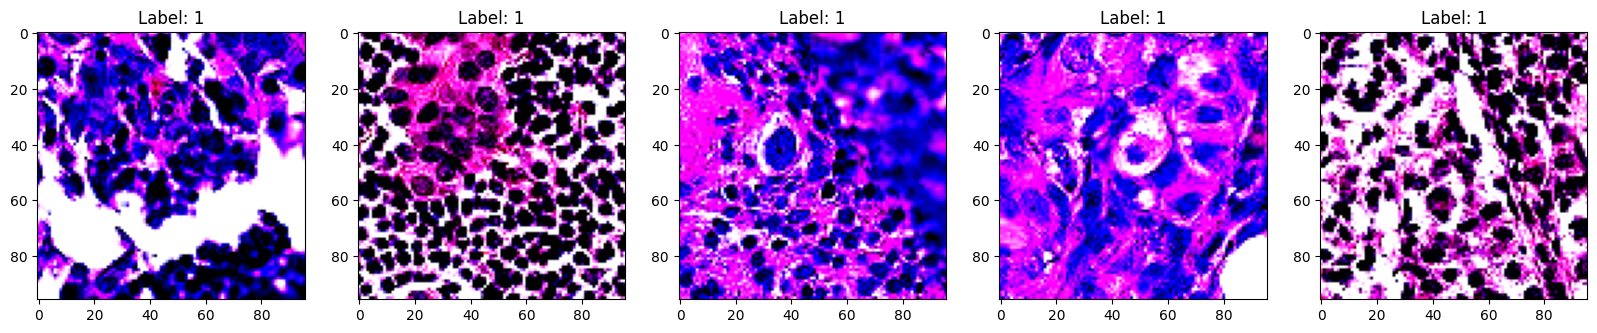

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


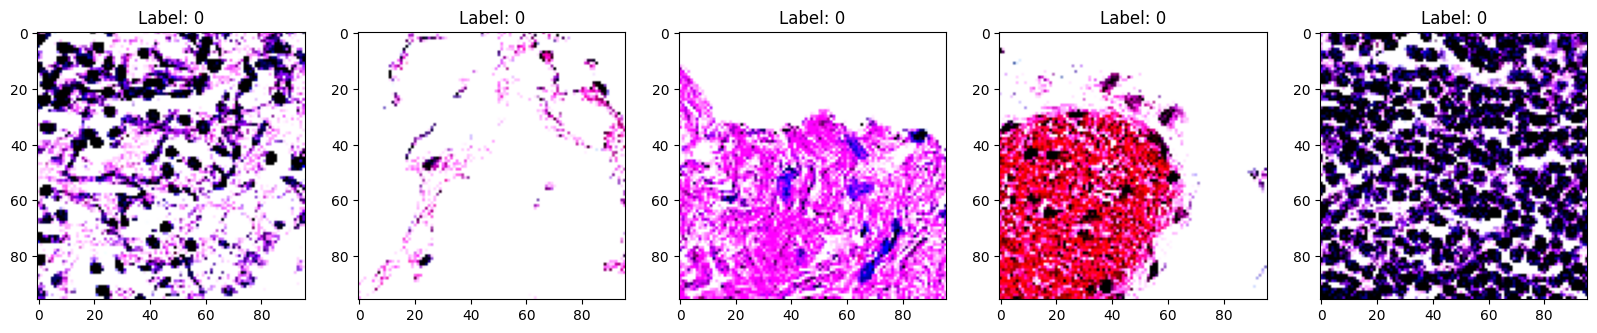

In [5]:
fig, ax = plt.subplots(1,5, figsize=(20,10))
for i in range(5):
    index = np.random.randint(0, len(data_train))
    while data_train[index][1] == 0:
        index = np.random.randint(0, len(data_train))

    ax[i].imshow(data_train[index][0].permute(1,2,0))
    ax[i].set_title('Label: %d' % data_train[index][1])
plt.show()

fig, ax = plt.subplots(1,5, figsize=(20,10))
for i in range(5):
    index = np.random.randint(0, len(data_train))
    while data_train[index][1] == 1:
        index = np.random.randint(0, len(data_train))

    ax[i].imshow(data_train[index][0].permute(1,2,0))
    ax[i].set_title('Label: %d' % data_train[index][1])
plt.show()

Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [6]:
data_loader_train = torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True)

#This is artificial, just for the running time to keep low.
nb_test_batches = 100
data_loader_test = torch.utils.data.DataLoader(data_test, batch_size=32, shuffle=True)

print('Number of training images: %s' % len(data_train))
print('Number of training batches: %s' % len(data_loader_train))

print('Number of test images: %s' % len(data_test))

Number of training images: 32768
Number of training batches: 1024
Number of test images: 32768


## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [7]:
def train_model(model, dataloader, epochs):
    model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_list = []
    acc_list = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        running_corrects = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            preds = torch.max(outputs, dim=1)[1]

            loss_value = loss(outputs, labels)
            loss_value.backward()

            optimizer.step()

            running_loss += loss_value.item()
            running_corrects += torch.sum(preds == labels.data).item()
        
        loss_list.append(running_loss / len(dataloader.dataset))
        acc_list.append(running_corrects / len(dataloader.dataset))
    
    return loss_list, acc_list

Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [8]:
def test_model(model, dataloader):
    model.to(device)
    loss = nn.CrossEntropyLoss()
    loss_list = []
    acc_list = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i == nb_test_batches:
                break
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss_list.append(loss(outputs, labels).item())
            preds = torch.max(outputs, dim=1)[1]
            acc_list.append(torch.sum(preds == labels.data).item() / len(preds))
    return np.mean(loss_list), np.mean(acc_list)

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

In [9]:
class linear_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*96*96, 2)
    def forward(self, x):
        #x shape: [batch_size, 3, 96, 96]
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [10]:
model = linear_model().to(device)

In [11]:
loss, acc = train_model(model, data_loader_train, 2)
print('Training loss: %s' % loss)
print('Training accuracy: %s' % acc)

  0%|          | 0/2 [00:00<?, ?it/s]

#####################

 50%|█████     | 1/2 [01:27<01:27, 87.92s/it]

#####################

100%|██████████| 2/2 [02:56<00:00, 88.18s/it]

Training loss: [0.07050003480162559, 0.06338006379883154]
Training accuracy: [0.58148193359375, 0.63372802734375]


In [12]:
loss, acc = test_model(model, data_loader_test)
print('Test loss: %s' % loss)
print('Test accuracy: %s' % acc)

Test loss: 2.601387823553523
Test accuracy: 0.60162353515625


## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [9]:
vgg16 = models.vgg16(weights='DEFAULT')

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [10]:
vgg_features = vgg16.features

for param in vgg_features.parameters():
    param.requires_grad = False
new_linear = nn.Linear(512*3*3, 2)

model = nn.Sequential(vgg_features, nn.Flatten(), new_linear).to(device)

Now fine-tune the model by performing 2 epochs of training.

In [25]:
%%time
loss, acc = train_model(model, data_loader_train, 2)
print('Training loss: %s' % loss)
print('Training accuracy: %s' % acc)

  0%|          | 0/2 [00:00<?, ?it/s]

#####################

 50%|█████     | 1/2 [17:26<17:26, 1046.42s/it]

#####################

100%|██████████| 2/2 [33:18<00:00, 999.32s/it] 

CPU times: total: 4h 25min 33s
Wall time: 33min 18s


([0.01122746329065194, 0.009248550385791532],
 [0.845550537109375, 0.876983642578125])

In [30]:
loss, acc = test_model(model, data_loader_test)

print('Test loss: %s' % loss)
print('Test accuracy: %s' % acc)

(0.8519550621509552, 0.763125)

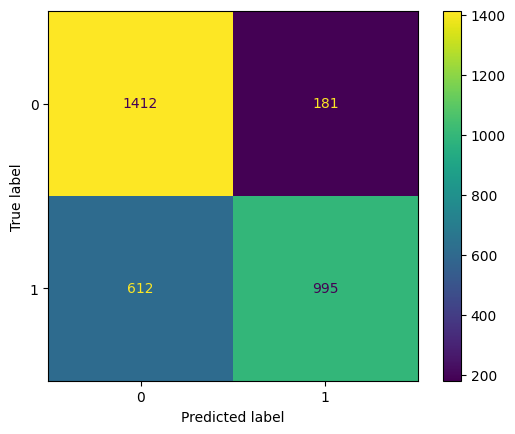

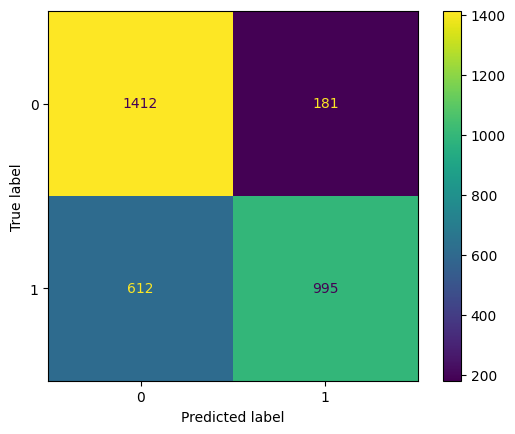

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    model.to(device)
    preds = []
    labels = []
    with torch.no_grad():
        for i, (inputs, label) in enumerate(dataloader):
            if i == nb_test_batches:
                break
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            preds.append(torch.max(outputs, dim=1)[1])
            labels.append(label.data)
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    ConfusionMatrixDisplay.from_predictions(labels.cpu(), preds.cpu())

plot_confusion_matrix(model, data_loader_test)

Super good for not telling you that you are ill if you are not, but super bad at telling you that you are ill.

## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [37]:
def precompute_model(model, dataloader):
    model.to(device)
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (inputs, label) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            features.append(outputs)
            labels.append(label)
    features = torch.cat(features)
    labels = torch.cat(labels)

    dataset = torch.utils.data.TensorDataset(features.cpu(), labels.cpu())
    
    return dataset

precomputed_train = precompute_model(vgg_features, data_loader_train)
precomputed_test = precompute_model(vgg_features, data_loader_test)

1024it [17:05,  1.00s/it]
1024it [1:23:27,  4.89s/it] 


Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [ ]:
%%time
#
# DONE
#

Finally, train a linear model on the our new precomputed features for 50 epochs. Is the model better?

In [1]:
%%time

model = nn.Sequential(nn.Flatten(), new_linear).to(device)

inputs, labels = next(iter(precomputed_train))
print(inputs.shape)
imputs = nn.Flatten()(inputs)
print(inputs.shape)

loss, acc = train_model(model, precomputed_train, 2)
print('Training loss: %s' % loss)
print('Training accuracy: %s' % acc)

NameError: name 'nn' is not defined